# Import needed modules

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define base data directory in Google Drive
data_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray'

# Define subdirectories for train, validation, and test
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Helper function to load file paths and labels
def load_paths_labels(directory, set_name):
    filepaths = []
    labels = []
    class_folders = os.listdir(directory)

    for folder in class_folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):  # Ensures we're looking at folders, not files
            file_list = os.listdir(folder_path)
            for file in file_list:
                file_path = os.path.join(folder_path, file)
                filepaths.append(file_path)
                labels.append(folder)  # Use folder name (NORMAL or PNEUMONIA) as the label

    # Create Fseries and Lseries, then combine into a DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    set_series = pd.Series([set_name] * len(filepaths), name='set')  # Add a column for the set name
    return pd.concat([Fseries, Lseries, set_series], axis=1)

# Load data paths and labels into a single DataFrame for all sets
train_df = load_paths_labels(train_dir, 'train')
val_df = load_paths_labels(val_dir, 'val')
test_df = load_paths_labels(test_dir, 'test')

# Concatenate all sets into a single DataFrame
df = pd.concat([train_df, val_df, test_df], axis=0).reset_index(drop=True)


Mounted at /content/drive


In [ ]:
df

,filepaths,labels,set
0,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,train
1,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,train
2,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,train
3,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,train
4,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,train
...,...,...,...
5851,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,test
5852,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,test
5853,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,test
5854,/content/drive/MyDrive/Colab Notebooks/chest_x...,PNEUMONIA,test


### **Split dataframe into train, valid, and test**

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [ ]:
# cropped image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4684 validated image filenames belonging to 2 classes.
Found 703 validated image filenames belonging to 2 classes.
Found 469 validated image filenames belonging to 2 classes.


### **Show sample from train data**

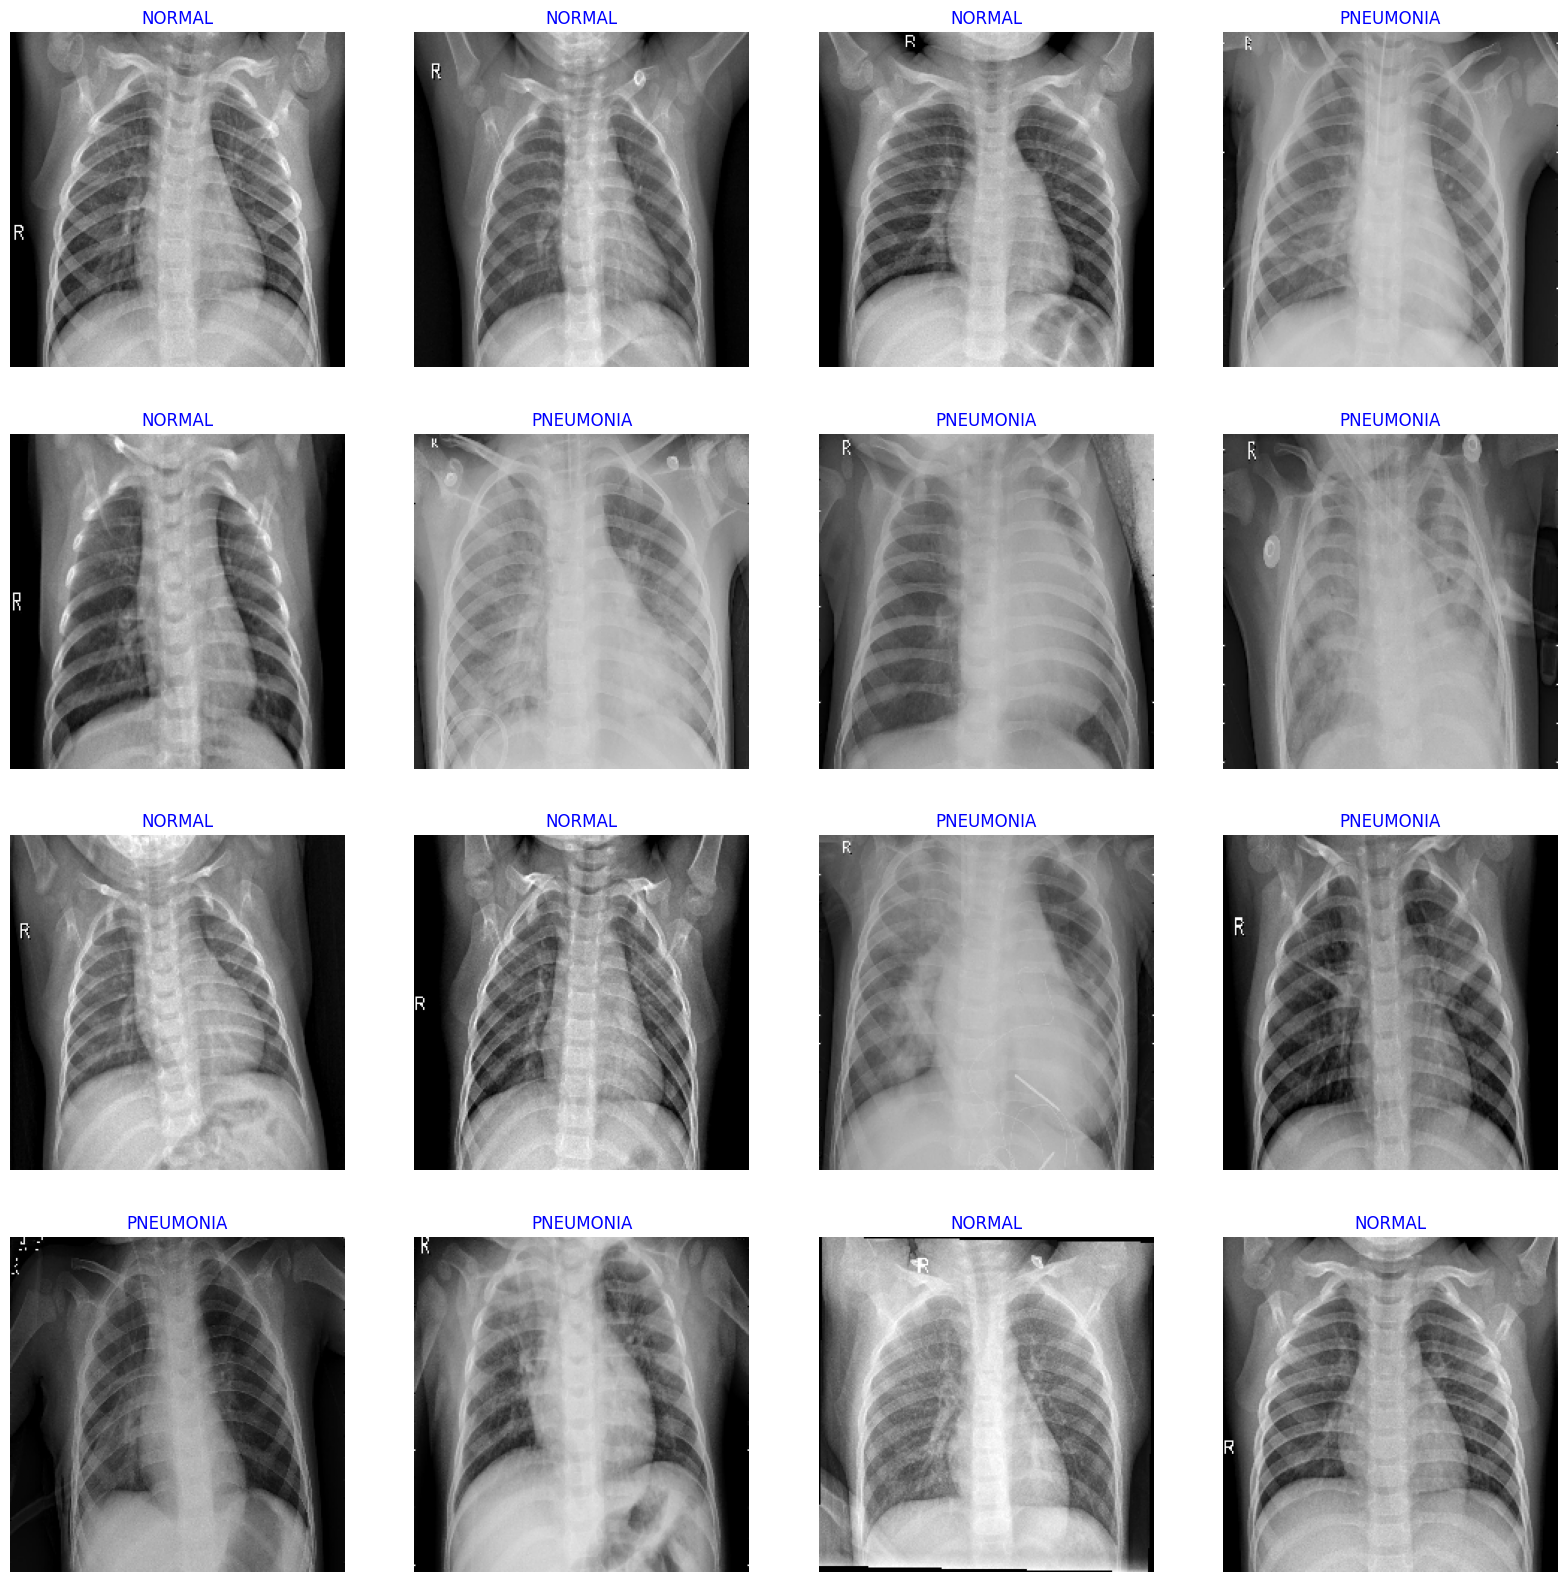

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-t

#### **Train model**

In [ ]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

start_time = time.time()

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)
end_time = time.time()


training_time = end_time - start_time
print(f"Total training time for {epochs} epochs: {training_time:.2f} seconds")

Epoch 1/10
293/293 [==============================] - 3278s 11s/step - loss: 4.0962 - accuracy: 0.9370 - val_loss: 2.8642 - val_accuracy: 0.8805
Epoch 2/10
293/293 [==============================] - 168s 572ms/step - loss: 2.1160 - accuracy: 0.9575 - val_loss: 1.5523 - val_accuracy: 0.9587
Epoch 3/10
293/293 [==============================] - 169s 575ms/step - loss: 1.2158 - accuracy: 0.9682 - val_loss: 0.8961 - val_accuracy: 0.9787
Epoch 4/10
293/293 [==============================] - 169s 577ms/step - loss: 0.7310 - accuracy: 0.9778 - val_loss: 0.5897 - val_accuracy: 0.9716
Epoch 5/10
293/293 [==============================] - 169s 576ms/step - loss: 0.4695 - accuracy: 0.9821 - val_loss: 0.3899 - val_accuracy: 0.9744
Epoch 6/10
293/293 [==============================] - 169s 575ms/step - loss: 0.3260 - accuracy: 0.9851 - val_loss: 0.2970 - val_accuracy: 0.9730
Epoch 7/10
293/293 [==============================] - 169s 574ms/step - loss: 0.2392 - accuracy: 0.9872 - val_loss: 0.2206 - 

#### **Display model performance**

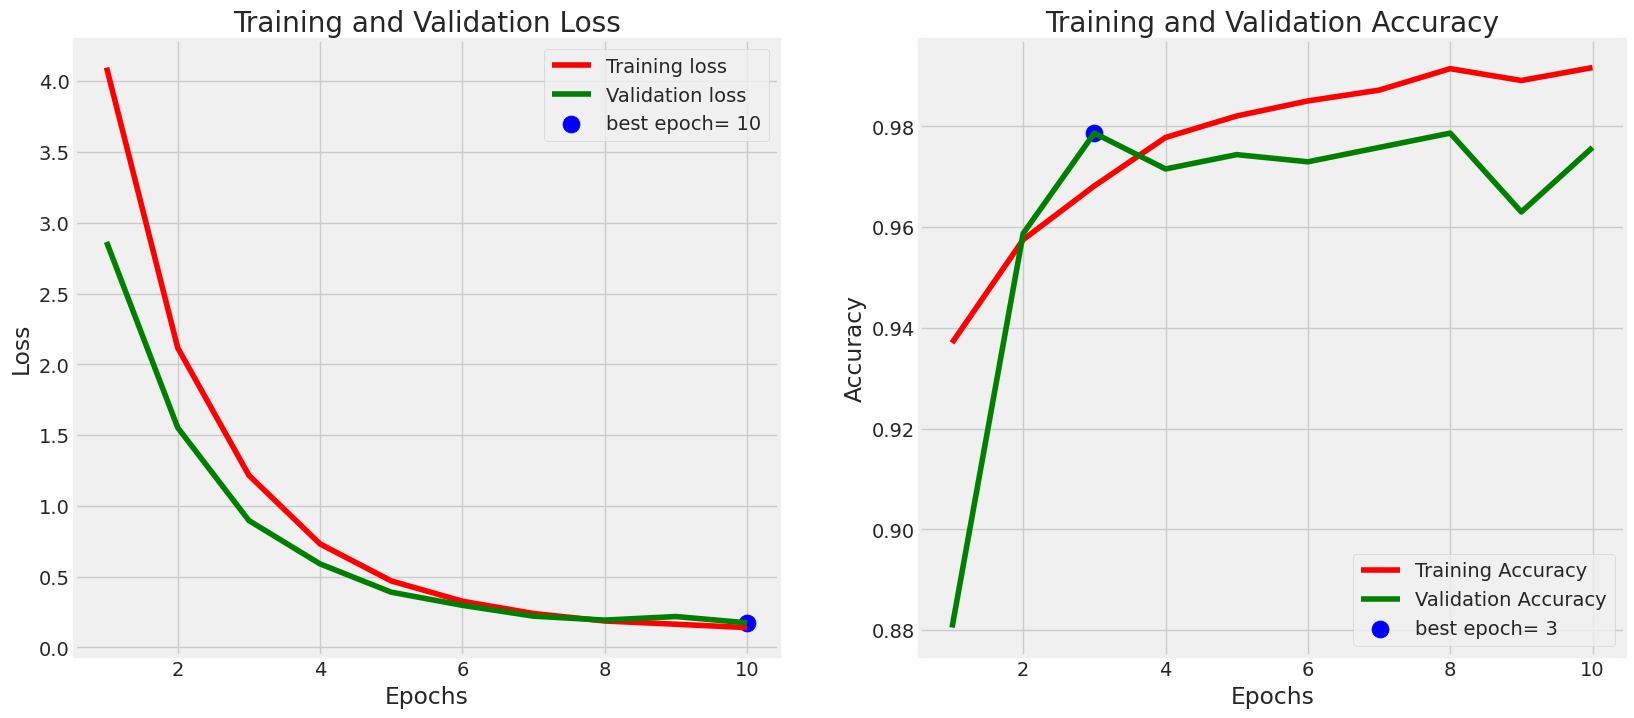

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 275s 46s/step - loss: 0.1624 - accuracy: 0.9787
Train Loss:  0.1098204106092453
Train Accuracy:  1.0
--------------------
Validation Loss:  0.2297551929950714
Validation Accuracy:  0.9375
--------------------
Test Loss:  0.1624261438846588
Test Accuracy:  0.9786780476570129


# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

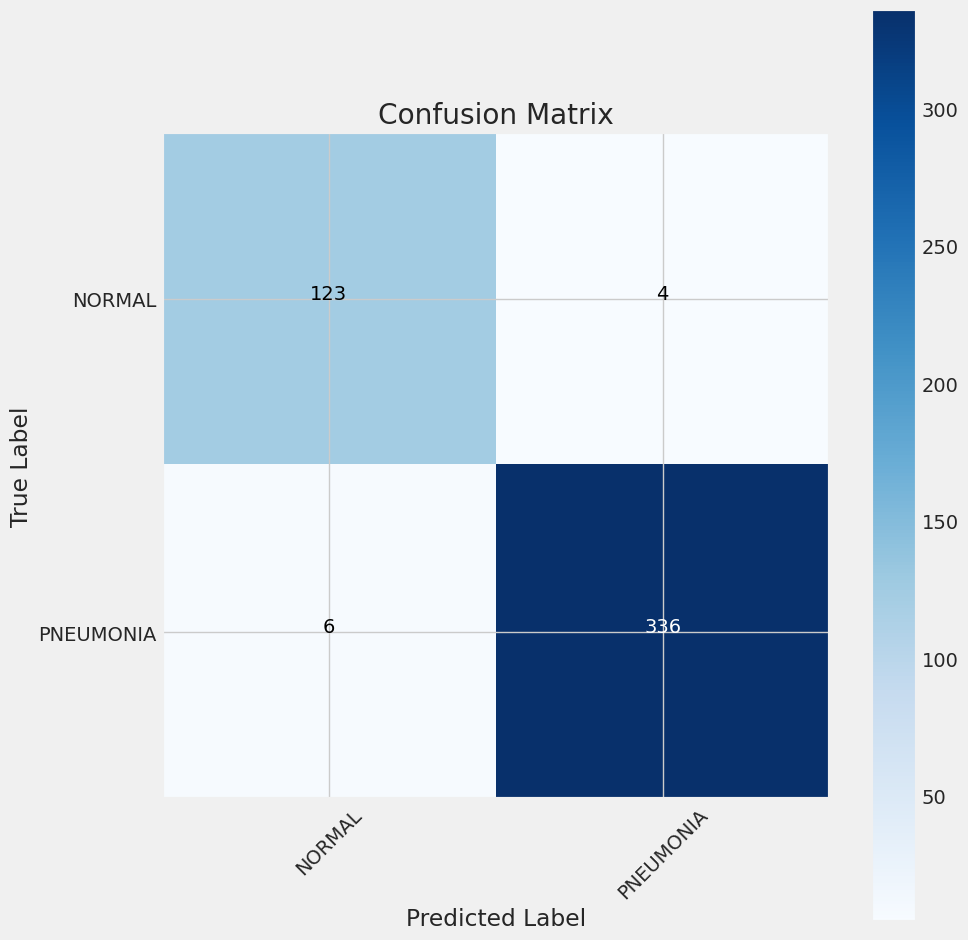

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.95      0.97      0.96       127
   PNEUMONIA       0.99      0.98      0.99       342

    accuracy                           0.98       469
   macro avg       0.97      0.98      0.97       469
weighted avg       0.98      0.98      0.98       469

